# Regression techniques for predicting House Prices

In this notebook, we will see different regression methods and how well do they predict on our dataset, together with methods like: <ul><li><b>Data transformation</b></li>
          <li><b>Label and Ordinal Encoding</b></li>
          <li><b>Handling missing values</b></li>
          <li><b>Getting Dummy Variables</b></li>
          <li><b>Feature Selection</b></li></ul>
The dataset used is from Kaggle, named [Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).


### Defining libraries and utility methods

Here we are defining the libraries and some functions that we will use later on our data:

In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.offline
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge, RidgeCV, LassoCV, LinearRegression, HuberRegressor, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy import stats
from scipy.stats import skew
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
sns.set()

plotly.offline.init_notebook_mode(connected=True)   # for offline mode use

def dataset_cleaning(filename, test=False):
    df = pd.read_csv(filename)
    if test:
        df2 = pd.read_csv("sample_submission.csv")
        cols = df2.columns.difference(df.columns)
        df = pd.concat([df, df2[cols]], join='inner', axis=1)
    print(df.info(), sep='\n')
    # with the garageX attributes, the only problem is GarageYrBlt because it is a year
    # and we the other garageX variables missing it will be hard for us to predict it
    # so we remove all rows where all of these garageX values are NA
    df.dropna(subset=["GarageType", "GarageYrBlt", "GarageQual", "GarageCond", "GarageFinish"], how='any',
                           inplace=True)
    # Electrical only has one NA as missing so we can safely remove it
    df.dropna(subset=["Electrical"], inplace=True)
    # MasVnrTyp and MasVnrArea have connected NA missing, so we drop
    # when both of them are NA
    df.dropna(subset=["MasVnrType", "MasVnrArea"], how="all", inplace=True)
    # values from these columns are NA in the test set, since the take like 1% of data, we can remove them
    df.dropna(subset=["SaleType", "Functional","KitchenQual","BsmtFullBath","BsmtUnfSF","Utilities","MasVnrType","MSZoning"], how="any", inplace=True)
    # fill the NA with No alley
    df["Alley"] = df["Alley"].fillna("No Alley")
    # all of these attributes have NA values, but those aren't missing values
    # those are type of categories, so we fill those NA with custom category
    df["BsmtQual"] = df["BsmtQual"].fillna("No Basement")
    df["BsmtCond"] = df["BsmtCond"].fillna("No Basement")
    df["BsmtExposure"] = df["BsmtExposure"].fillna("No Basement")
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("No Basement")
    df["BsmtFinType2"] = df["BsmtFinType2"].fillna("No Basement")
    df["FireplaceQu"] = df["FireplaceQu"].fillna("No Fireplace")
    df["PoolQC"] = df["PoolQC"].fillna("No Pool")
    df["Fence"] = df["Fence"].fillna("No Fence")
    df["MiscFeature"] = df["MiscFeature"].fillna("None")

    # df["MSSubClass"] = df["MSSubClass"].astype("category")
    # the only one left with NA is LotFrontage, but since is numerical
    # and we kind of have sufficient data, we can try to fill the NA by prediction

    return df



def map_to_ordinal(df):
    exter_mapper = dict([('No Basement', 0), ('No Fireplace', 0), ("Po", 1), ("Fa", 2), ("TA", 3), ('Gd', 4), ("Ex", 5)])
    pool_mapper = dict([('No Pool', 0), ("Fa", 1), ("TA", 2), ('Gd', 3), ("Ex", 4)])
    bsmt_fin_mapper = dict([("No Basement", 0), ("Unf", 1), ("LwQ", 2), ("Rec", 3), ("BLQ", 4), ("ALQ", 5), ("GLQ", 6)])
    fence_mapper = dict([('No Fence', 0), ('MnWw', 1), ('GdWo', 2), ('MnPrv', 3), ('GdPrv', 4)])
    bsm_exposure_mapper = dict([('No Basement', 0), ('No', 1), ('Mn', 2), ('Av', 3), ('Gd', 4)])
    df["ExterQual"] = df["ExterQual"].apply(lambda x: exter_mapper[x])
    df["ExterCond"] = df["ExterCond"].apply(lambda x: exter_mapper[x])
    df["KitchenQual"] = df["KitchenQual"].apply(lambda x: exter_mapper[x])
    df["HeatingQC"] = df["HeatingQC"].apply(lambda x: exter_mapper[x])
    df["PoolQC"] = df["PoolQC"].apply(lambda x: pool_mapper[x])
    df["BsmtQual"] = df["BsmtQual"].apply(lambda x: exter_mapper[x])
    df["BsmtCond"] = df["BsmtCond"].apply(lambda x: exter_mapper[x])
    df["FireplaceQu"] = df["FireplaceQu"].apply(lambda x: exter_mapper[x])
    df["GarageQual"] = df["GarageQual"].apply(lambda x: exter_mapper[x])
    df["GarageCond"] = df["GarageCond"].apply(lambda x: exter_mapper[x])
    df["BsmtFinType1"] = df["BsmtFinType1"].apply(lambda x: bsmt_fin_mapper[x])
    df["BsmtFinType2"] = df["BsmtFinType2"].apply(lambda x: bsmt_fin_mapper[x])
    df["Fence"] = df["Fence"].apply(lambda x: fence_mapper[x])
    df["BsmtExposure"] = df["BsmtExposure"].apply(lambda x: bsm_exposure_mapper[x])

    return df

# sign-flip the RMSE for parameter search
scorer = make_scorer(mean_squared_error, greater_is_better = False)
# R2 scorer
scorer2 = make_scorer(r2_score, greater_is_better = True)

def rmse_cv(model, x, y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring = scorer, cv = 10))
    return(rmse)

def r2(model, x, y):
    return cross_val_score(model, x, y, scoring = scorer2, cv=10)


### Importing the train and test dataset

From the start, the dataset it's split on train and test, so we don't have to use additional spliting. However, we can see that the train dataset has 1460 rows, while test has 1459 rows, which shows us is **50-50 split**(unlike the usual 80-75 with 20-25).
<br>
<br>
We also see that there are many null values however, with the given **description file** most of the null values refer to a category(categorical and ordinal values **only**). 
After cleaning the dataset, we can see that we still have one column with null values: **LotFrontage**.
<br>
Since **LotFrontage** has ~200 missing values, which is 15% of our cleaned dataset, we will try later on to fill the missing values by predicting.
<br>
<br>
After cleaning the train and test dataset, we will map the ordinal values from strings to numbers. Since all of the ordinal values are ratings, basic replacement will suffice.

In [2]:
# importing the training set
df_train = dataset_cleaning("train.csv")
# importing the test set
df_test = dataset_cleaning("test.csv", True)

print("\n\n\nAfter cleaning both train and test datasets:")
print(df_train.info())
print(df_test.info())

# mapping the train and test attributes to ordinal
df_train = map_to_ordinal(df_train)
df_test = map_to_ordinal(df_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Plotting the Sale Price column

From the plots, we can see that dependent column distribution is positively skewed. That means we can apply **log transformation**(linear tranformation) so later on our dependent column will have linear relationship with the other columns.
<br>
<br>
Since there are no zero or negative values, we don't need to remove any outliers for this column.

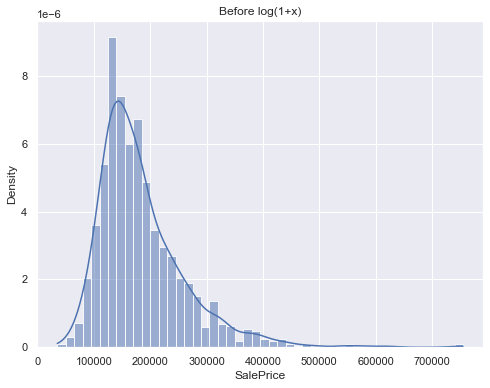

In [3]:
#plotting target column
f,a=plt.subplots(figsize=(8,6))
plt.title('Before log(1+x)')
sns.histplot(df_train['SalePrice'], stat='density', kde=True)
plt.show()



obj = go.Box(y=df_train["SalePrice"], name="Sale Price", boxmean='sd', boxpoints = 'all')
fig = go.Figure([obj])
plotly.offline.iplot(fig, filename="Sale Price Box Plot")

### Correlation matrix

Here we want to see how much correlated are the independent columns with the dependent **SalePrice**.
<br>
As a metric we are choosing the **Spearman Correlation Metric** since it checks monotony, which we can see if there is any relation beside the linear one and it works well with ordinal and continous variables together.

In [4]:
# next let us see the correlation between the dependent variable and the attributes
# since our data is most categorical, its better to use pearson rank correlation because it works both
# for discrete and continuous variables
corrmat = df_train.corr(method='spearman')
layout = go.Layout(width=1000,
                   height=1000,
                   autosize=False)
obj = go.Heatmap(z=corrmat.values, x=corrmat.columns.values, y=corrmat.columns.values)
fig = go.Figure([obj], layout)
plotly.offline.iplot(fig, filename="Correlation matrix")


### Plotting correlated features

For our plot, we will get all the features that have absolute value above 0.5 with the dependent **SalePrice**.

In [5]:
obj = go.Splom(dimensions=[dict(label='OverallQual', values = df_train['OverallQual']),
                           dict(label='GrLivArea', values=df_train['GrLivArea']),
                           dict(label='GarageCars', values=df_train['GarageCars']),
                           dict(label='GarageArea', values=df_train['GarageArea']),
                           dict(label='TotalBsmtSF', values=df_train['TotalBsmtSF']),
                           dict(label='1stFlrSF', values=df_train['1stFlrSF']),
                           dict(label='FullBath', values=df_train['FullBath']),
                           dict(label='YearBuilt', values=df_train['YearBuilt']),
                           dict(label='YearRemodAdd', values=df_train['YearRemodAdd']),
                           dict(label='TotRmsAbvGrd', values=df_train['TotRmsAbvGrd']),
                           dict(label='Fireplaces', values=df_train['Fireplaces']),
                           dict(label='KitchenQual', values=df_train['KitchenQual']),
                           dict(label='FireplaceQu', values=df_train['FireplaceQu']),
                           dict(label='BsmtQual', values=df_train['BsmtQual']),
                           dict(label='ExterQual', values=df_train['ExterQual']),
                           dict(label='GarageYrBlt', values=df_train['GarageYrBlt']),
                           dict(label='HeatingQC', values=df_train['HeatingQC']),
                           dict(label='SalePrice', values=df_train['SalePrice'])],
                        marker=dict(size=5,
                           line=dict(width=0.5,
                                     color='rgb(230,230,230)')),
                           diagonal=dict(visible=False),
                           showupperhalf=False)
axisd = dict(showline=False,
           zeroline=False,
           gridcolor='#fff')

layout = go.Layout(title="Pairplot for house pricing",
                   dragmode='select',
                   width=2000,
                   height=2000,
                   autosize=False,
                   hovermode='closest',
                   plot_bgcolor='rgba(240,240,240, 0.95)',
                   xaxis1=dict(axisd), xaxis2=dict(axisd), xaxis3=dict(axisd), xaxis4=dict(axisd), xaxis5=dict(axisd), xaxis6=dict(axisd),
                   xaxis7=dict(axisd), xaxis8=dict(axisd), xaxis9=dict(axisd), xaxis10=dict(axisd), xaxis11=dict(axisd), xaxis12=dict(axisd),
                   xaxis13=dict(axisd), xaxis14=dict(axisd), xaxis15=dict(axisd), xaxis16=dict(axisd), xaxis17=dict(axisd), xaxis18=dict(axisd),
                   yaxis1=dict(axisd), yaxis2=dict(axisd), yaxis3=dict(axisd), yaxis4=dict(axisd), yaxis5=dict(axisd), yaxis6=dict(axisd),
                   yaxis7=dict(axisd), yaxis8=dict(axisd), yaxis9=dict(axisd), yaxis10=dict(axisd), yaxis11=dict(axisd), yaxis12=dict(axisd),
                   yaxis13=dict(axisd), yaxis14=dict(axisd), yaxis15=dict(axisd), yaxis16=dict(axisd), yaxis17=dict(axisd), yaxis18=dict(axisd))


fig = go.Figure(data=[obj], layout=layout)
plotly.offline.iplot(fig, filename="pairplot")

### Removing outliers and tranforming Sale Price

As we can see from the plot above, there are few points that don't fit with the crowd. There are especially visible on **GrLivArea** and **SalePrice** plot. It is very unusual to have a house with that big living area, basement area and overall quality and still have very low price. So we can safely remove them.
<br>
We said before that we will apply **log transformation** on **SalePrice**. We are doing that in this step.

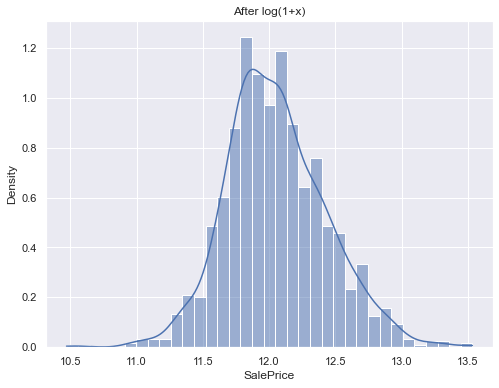

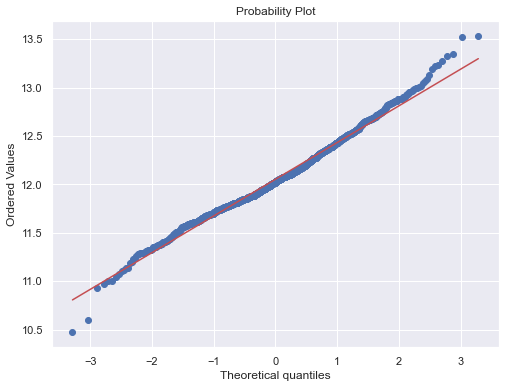

In [6]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<200000)].index)

#log it
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
df_test['SalePrice'] = np.log1p(df_test['SalePrice'])
#plot again
f,a=plt.subplots(figsize=(8,6))
plt.title('After log(1+x)')
sns.histplot(df_train['SalePrice'], stat='density', kde=True)
f,a=plt.subplots(figsize=(8,6))
stats.probplot(df_train['SalePrice'],plot=plt)
plt.show()

### Transforming skewed features and dummy variables

Here we want to see how much our features are skewed and later on get dummy variables. 
<br>
For positively skewed values we will apply **log1p transformation**(we add + 1 when we do log for values that are zero), and for negatively skewed we apply **square transformation**. 
<br>
We apply these tranformations for values above 0.7 and -0.7 respectively.
<br>
After we do the dummy variable transformation, we drop the first column of each transformation to avoid **dummy variable trap**.

In [7]:
rtrain = df_train.shape[0]
rtest = df_test.shape[0]
all_data = pd.concat([df_train, df_test], ignore_index=True)



numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
categorical_features = all_data.select_dtypes(include = ["object"]).columns


all_data_cat = all_data[categorical_features]
all_data_num = all_data[numerical_features]

# log(1+x) transform all skewed columns
skewness = all_data_num.apply(lambda x: skew(x))
print(skewness)
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
pos_skewness = skewness[skewness >= 0.7]
neg_skewness = skewness[skewness <= -0.7]
print(str(pos_skewness.shape[0]) + " pos skewed numerical features to log transform")
print(str(neg_skewness.shape[0]) + " neg skewed numerical features to square transform")
pos_skewed_features = pos_skewness.index
neg_skewed_features = neg_skewness.index
# log tranformation on positively skewed attributes
all_data_num[pos_skewed_features] = np.log1p(all_data_num[pos_skewed_features])
# cube transformation on negatively skewed attributes
# gives slightly better results than log1p
all_data_num[neg_skewed_features] = np.power(all_data_num[neg_skewed_features], 2)
# concate them back
all_data = pd.concat([all_data_num, all_data_cat], axis = 1)


# converting categorical values to dummy variables
all_data = pd.get_dummies(all_data, drop_first=True)
print("The shape of total data:", all_data.shape)


Id                0.004705
MSSubClass        1.358549
LotFrontage            NaN
LotArea          13.440634
OverallQual       0.269545
OverallCond       0.863314
YearBuilt        -0.637030
YearRemodAdd     -0.484829
MasVnrArea        2.531692
ExterQual         0.819422
ExterCond         1.727790
BsmtQual         -1.189896
BsmtCond         -3.819136
BsmtExposure      1.104670
BsmtFinType1     -0.201375
BsmtFinSF1        0.954086
BsmtFinType2      3.104788
BsmtFinSF2        4.038647
BsmtUnfSF         0.946247
TotalBsmtSF       0.751679
HeatingQC        -0.573775
1stFlrSF          1.186795
2ndFlrSF          0.844474
LowQualFinSF     14.153972
GrLivArea         1.072963
BsmtFullBath      0.502620
BsmtHalfBath      3.767142
FullBath          0.121312
HalfBath          0.642428
BedroomAbvGr      0.140577
KitchenAbvGr      5.037699
KitchenQual       0.458830
TotRmsAbvGrd      0.737173
Fireplaces        0.661628
FireplaceQu       0.086931
GarageYrBlt      -0.651351
GarageCars        0.300216
G

c:\users\zelen\anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Predicting LotFrontage

This is where we will try to predict or fill the null values in LotFrontage. However, for predicting we won't use **SalePrice** for reasons to avoid colinearity and we will merge the train and test set, so we can predict the values on both datasets.
<br>
Firstly, we will see the distribution if we need to apply some transformation. We can see that is positively skewed, so we apply log transformation.

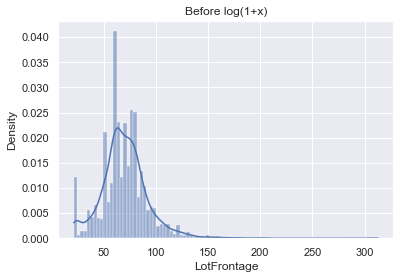

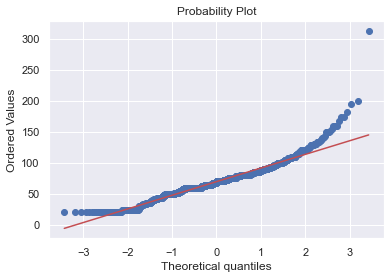

c:\users\zelen\anaconda3\envs\py37\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



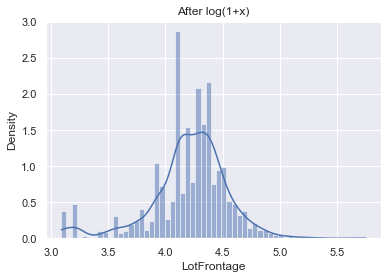

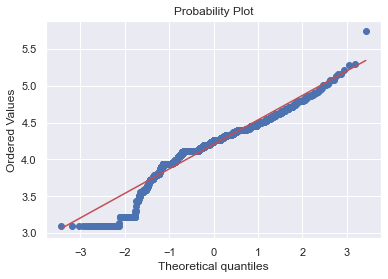

In [8]:
lot_frontage_df = all_data.copy()
lot_frontage_df = lot_frontage_df.drop('SalePrice', axis=1)

train = lot_frontage_df[~lot_frontage_df.LotFrontage.isnull()]
test = lot_frontage_df[lot_frontage_df.LotFrontage.isnull()]
y_train = train.LotFrontage

sns.histplot(train.LotFrontage, stat='density', kde=True)
plt.title("Before log(1+x)")
plt.show()
stats.probplot(train.LotFrontage,plot=plt)
plt.show()

all_data["LotFrontage"] = all_data["LotFrontage"].apply(lambda x: np.log1p(x) if not pd.isna(x) else x)
df_train = all_data[:rtrain]
df_test = all_data[rtrain:]

train.LotFrontage = train.LotFrontage.apply(lambda x: np.log1p(x) if not pd.isna(x) else x)

sns.histplot(train.LotFrontage, stat='density', kde=True)
plt.title("After log(1+x)")
plt.show()
stats.probplot(train.LotFrontage,plot=plt)
plt.show()

y_train = train.LotFrontage
X_train = train.drop("LotFrontage", axis=1)

In [9]:
#est = LinearRegression()
#est = RidgeCV(alphas=[0.01, 0.04, 0.08, 0.1, 0.4, 0.8, 1, 4, 8, 10, 40])
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
est = LassoCV(alphas = [0.0001, 0.0004, 0.0008, 0.001, 0.004, 0.008, 0.01, 0.04, 0.08, 0.1,
                          0.4, 0.8, 1],
                max_iter = 50000, cv = 10)
#est = BayesianRidge(n_iter=300, tol=1e-2)
#est = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
#                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
#                                   0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
#                          max_iter = 50000, cv = 10)
# Bayesian Ridge RMSE: 0.165
# Ridge RMSE: 0.164
# Lasso RMSE: 0.163
# ElasticNet RMSE: 0.162 (gives unstable result later when predicting SalePrice)
# LinearRegression RMSE: 0.174
featureSelection = SelectFromModel(est)
featureSelection.fit(X_train, y_train)
selectedFeatures = featureSelection.transform(X_train)
print("The new shaped training data:", selectedFeatures.shape)
selectedColumns = X_train.columns[featureSelection.get_support()]
print("Selected Columns:", selectedColumns)
test = test[selectedColumns]

print("LotFrontage RMSE:", rmse_cv(est, selectedFeatures, y_train).mean())
print("LotFrontage R2:", r2(est, selectedFeatures, y_train).mean())
est.fit(selectedFeatures, y_train)
predicted = est.predict(test)

The new shaped training data: (2257, 73)
Selected Columns: Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'GarageQual', 'WoodDeckSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscVal', 'YrSold',
       'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'Alley_No Alley',
       'LotShape_IR2', 'LandContour_HLS', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_Inside', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Sawyer', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber',

In [10]:
# the first 250 values predicted belongs to the df_train
index_train = df_train["LotFrontage"].index[df_train["LotFrontage"].apply(np.isnan)]
index_test = df_test["LotFrontage"].index[df_test["LotFrontage"].apply(np.isnan)]
for elem, ind in zip(predicted[:250], index_train):
    df_train.loc[ind, "LotFrontage"] = elem

for elem, ind in zip(predicted[250:], index_test):
    df_test.loc[ind, "LotFrontage"] = elem

print("Train LotFrontage null values:",df_train.LotFrontage.isnull().sum())
print("Test LotFrontage null values:", df_test.LotFrontage.isnull().sum())

Train LotFrontage null values: 0
Test LotFrontage null values: 0


c:\users\zelen\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Finally, predicting Sale Price

After takking care of all null values, we can move on to predicting **SalePrice**.

In [11]:
Y_train = df_train["SalePrice"]
X_train = df_train.drop("SalePrice", axis=1)

Y_test = df_test["SalePrice"]
X_test = df_test.drop("SalePrice", axis=1)



print(X_train.shape, X_test.shape)


(1368, 210) (1356, 210)


In [12]:
ridgecv = RidgeCV(alphas=[0.01, 0.04, 0.08, 0.1, 0.4, 0.8, 1, 1.5, 4, 8, 10, 40, 60],normalize=True)
featureSelection = SelectFromModel(ridgecv, threshold=0.2)
featureSelection.fit(X_train, Y_train)

selectedColumns = X_train.columns[featureSelection.get_support()]
X_train_new = featureSelection.transform(X_train)
print("Shape of new data:", X_train_new.shape)
print("Selected Columns:", selectedColumns)
X_test_new = featureSelection.transform(X_test)


ridgecv.fit(X_train_new, Y_train)
alpha = ridgecv.alpha_
print("Best initial alpha Ridge:", alpha)

ridgecv = RidgeCV(alphas = [alpha * .7, alpha * .75, alpha * .8, alpha * .85,
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3], cv = 10,normalize=True)

ridgecv.fit(X_train_new, Y_train)
alpha_ridge = ridgecv.alpha_
print("Best alpha Ridge:", alpha_ridge)


print("Train RMSE for Ridge:", rmse_cv(ridgecv, X_train_new, Y_train).mean())
print("Test RMSE for Ridge:", rmse_cv(ridgecv, X_test_new, Y_test).mean())

# Final scoring
reg=Ridge(alpha=alpha_ridge, normalize=True)
reg.fit(X_train_new,Y_train)
predicted = reg.predict(X_test_new)
print("RMSE Ridge test final log: %.3f"
      % np.sqrt(mean_squared_error(Y_test, predicted)))
print("RMSE Ridge final: %.3f"
      % np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(predicted))))


Shape of new data: (1368, 15)
Selected Columns: Index(['OverallCond', 'GrLivArea', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Utilities_NoSeWa', 'Condition2_PosA', 'Condition2_RRAe',
       'RoofStyle_Shed', 'RoofMatl_Membran', 'Exterior1st_BrkComm',
       'Functional_Sev', 'SaleType_Oth', 'SaleCondition_AdjLand'],
      dtype='object')
Best initial alpha Ridge: 0.01
Best alpha Ridge: 0.006999999999999999
Train RMSE for Ridge: 0.23498964461052055
Test RMSE for Ridge: 0.06893453895506987
RMSE Ridge test final log: 0.263
RMSE Ridge final: 44774.241


In [13]:
lassocv = LassoCV(alphas = [0.0001, 0.0004, 0.0008, 0.001, 0.004, 0.008, 0.01, 0.04, 0.08, 0.1,
                         0.4, 0.8, 1],
               max_iter = 70000, cv = 10, normalize=True)
featureSelection = SelectFromModel(lassocv, threshold = 0.15)
featureSelection.fit(X_train, Y_train)

selectedColumns = X_train.columns[featureSelection.get_support()]
X_train_new = featureSelection.transform(X_train)
print("Shape of new data:", X_train_new.shape)
print("Selected Columns:", selectedColumns)
X_test_new = featureSelection.transform(X_test)


lassocv.fit(X_train_new, Y_train)
alpha = lassocv.alpha_
print("Best initial alpha Lasso:", alpha)

lassocv = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8,
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05,
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35,
                          alpha * 1.4],
                max_iter = 70000, cv = 10, normalize=True)

lassocv.fit(X_train_new, Y_train)
alpha = lassocv.alpha_
print("Best alpha Lasso:", alpha)


print("Train RMSE for Lasso:", rmse_cv(lassocv, X_train_new, Y_train).mean())
print("Test RMSE for Lasso:", rmse_cv(lassocv, X_test_new, Y_test).mean())

# Final scoring
reg = Lasso(alpha=alpha, normalize=True)
reg.fit(X_train_new,Y_train)
predicted = reg.predict(X_test_new)
print("RMSE Lasso final log: %.3f"
      % np.sqrt(mean_squared_error(Y_test, predicted)))
print("RMSE Lasso final: %.3f"
      % np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(predicted))))


Shape of new data: (1368, 4)
Selected Columns: Index(['OverallCond', 'GrLivArea', 'KitchenAbvGr', 'Functional_Sev'], dtype='object')
Best initial alpha Lasso: 0.0001
Best alpha Lasso: 6e-05
Train RMSE for Lasso: 0.24302289265350013
Test RMSE for Lasso: 0.07310210680990856
RMSE Lasso final log: 0.254
RMSE Lasso final: 45180.789


In [14]:
bayesianridge = BayesianRidge(tol=1e-5,alpha_1=40, alpha_2=52, fit_intercept=True, normalize=True)
featureSelection = SelectFromModel(bayesianridge, threshold=0.13)
featureSelection.fit(X_train, Y_train)

selectedColumns = X_train.columns[featureSelection.get_support()]
X_train_new = featureSelection.transform(X_train)
print("Shape of new data:", X_train_new.shape)
print("Selected Columns:", selectedColumns)
X_test_new = featureSelection.transform(X_test)

print("Train RMSE for BayesianRidge", rmse_cv(bayesianridge, X_train_new, Y_train).mean())
print("Test RMSE for BayesianRidge", rmse_cv(bayesianridge, X_test_new, Y_test).mean())

bayesianridge.fit(X_train_new,Y_train)
predicted = bayesianridge.predict(X_test_new)
print("RMSE BayesianRidge log final: %.3f"
      % np.sqrt(mean_squared_error(Y_test, predicted)))
print("RMSE BayesianRidge final: %.3f"
      % np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(predicted))))


Shape of new data: (1368, 8)
Selected Columns: Index(['OverallCond', 'GrLivArea', 'Utilities_NoSeWa', 'Neighborhood_MeadowV',
       'Condition2_PosA', 'RoofMatl_WdShngl', 'Exterior1st_BrkComm',
       'Functional_Sev'],
      dtype='object')
Train RMSE for BayesianRidge 0.2552540953170117
Test RMSE for BayesianRidge 0.07386488044747355
RMSE BayesianRidge log final: 0.242
RMSE BayesianRidge final: 41934.907


In [15]:
reg = LinearRegression(normalize=True)
featureSelection = SelectFromModel(reg, threshold=0.3)
featureSelection.fit(X_train, Y_train)

selectedColumns = X_train.columns[featureSelection.get_support()]
X_train_new = featureSelection.transform(X_train)
print("Shape of new data:", X_train_new.shape)
print("Selected Columns:", selectedColumns)
X_test_new = featureSelection.transform(X_test)

print("Train RMSE for LinearRegression", rmse_cv(reg, X_train_new, Y_train).mean())
print("Test RMSE for LinearRegression", rmse_cv(reg, X_test_new, Y_test).mean())


reg.fit(X_train_new,Y_train)
predicted = reg.predict(X_test_new)
print("RMSE LinearRegression log final: %.3f"
      % np.sqrt(mean_squared_error(Y_test, predicted)))
print("RMSE LinearRegression final: %.3f"
      % np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(predicted))))

Shape of new data: (1368, 10)
Selected Columns: Index(['GrLivArea', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Exterior1st_CBlock', 'Exterior2nd_CBlock', 'MiscFeature_None',
       'MiscFeature_Othr', 'SaleType_Oth'],
      dtype='object')
Train RMSE for LinearRegression 0.23565660801362634
Test RMSE for LinearRegression 0.0688438196636935
RMSE LinearRegression log final: 0.264
RMSE LinearRegression final: 44618.900


In [16]:
xgbreg = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7,)
featureSelection = SelectFromModel(xgbreg, threshold=0.07)
featureSelection.fit(X_train, Y_train)

selectedColumns = X_train.columns[featureSelection.get_support()]
X_train_new = featureSelection.transform(X_train)
print("Shape of new data:", X_train_new.shape)
print("Selected Columns:", selectedColumns)
X_test_new = featureSelection.transform(X_test)

print("Train RMSE for XGBRegressor", rmse_cv(reg, X_train_new, Y_train).mean())
print("Test RMSE for XGBRegressor", rmse_cv(reg, X_test_new, Y_test).mean())


xgbreg.fit(X_train_new,Y_train)
predicted = xgbreg.predict(X_test_new)
print("RMSE XGBRegressor log final: %.3f"
      % np.sqrt(mean_squared_error(Y_test, predicted)))
print("RMSE XGBRegressor final: %.3f"
      % np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(predicted))))


[02:55:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Shape of new data: (1368, 1)
Selected Columns: Index(['GarageFinish_Unf'], dtype='object')
Train RMSE for XGBRegressor 0.31788566631771636
Test RMSE for XGBRegressor 0.08724299691216622
[02:55:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE XGBRegressor log final: 0.225
RMSE XGBReg

#### Little bonus

After the machine learning methods were tested, lets try with Deep Learning.

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam, SGD, Nadam
from keras.regularizers import l1, l1_l2, l2
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K

def rmse_dl(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


regressor = Sequential()
regressor.add(Dense(units=6, input_dim=X_train.shape[1],activation='linear',  kernel_initializer='random_uniform'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))
# if we want to reduce rmse/increase training error, uncomment this
#regressor.add(Dense(units=10, activation='relu', kernel_initializer='random_uniform',activity_regularizer=l1_l2(0.5, 0.5)))
#regressor.add(BatchNormalization())
regressor.add(Dense(units=5, activation='linear', kernel_initializer='random_uniform', activity_regularizer=l1(6.8)))
regressor.add(BatchNormalization())
regressor.add(Dense(units=1))

#decay=0.000002
adam = Nadam(lr=0.0005, schedule_decay=0.004)
regressor.compile(optimizer=adam, loss='mse', metrics=[rmse_dl])
#EarlyStopping(monitor='val_loss',min_delta=1e-5, patience=57)
regressor.fit(X_train, Y_train, batch_size=32, epochs=550, shuffle=True, 
              validation_split=0.1, verbose=1)
sgd = SGD(lr=0.0000002, decay=0.000001,momentum=0.7 ,nesterov=True)
regressor.compile(optimizer=sgd, loss='mse', metrics=[rmse_dl])
regressor.fit(X_train, Y_train, batch_size=32, epochs=25, shuffle=True, 
              validation_split=0.1, verbose=1)
predicted = regressor.predict(X_test)
print("RMSE Neural Network log final: %.3f"
      % np.sqrt(mean_squared_error(Y_test, predicted)))
print("RMSE Neural Network final: %.3f"
      % np.sqrt(mean_squared_error(np.expm1(Y_test), np.expm1(predicted))))

Epoch 1/550
39/39 [==============================] - 0s 10ms/step - loss: 146.4315 - rmse_dl: 12.0292 - val_loss: 173.5526 - val_rmse_dl: 11.4511
Epoch 2/550
39/39 [==============================] - 0s 6ms/step - loss: 143.1192 - rmse_dl: 11.9350 - val_loss: 147.0977 - val_rmse_dl: 11.6290
Epoch 3/550
39/39 [==============================] - 0s 6ms/step - loss: 140.5686 - rmse_dl: 11.8365 - val_loss: 135.6256 - val_rmse_dl: 11.5075
Epoch 4/550
39/39 [==============================] - 0s 6ms/step - loss: 137.9336 - rmse_dl: 11.7269 - val_loss: 130.1626 - val_rmse_dl: 11.3586
Epoch 5/550
39/39 [==============================] - 0s 6ms/step - loss: 135.1771 - rmse_dl: 11.6121 - val_loss: 127.2514 - val_rmse_dl: 11.2444
Epoch 6/550
39/39 [==============================] - 0s 6ms/step - loss: 132.2653 - rmse_dl: 11.4916 - val_loss: 123.2283 - val_rmse_dl: 11.0226
Epoch 7/550
39/39 [==============================] - 0s 5ms/step - loss: 129.2258 - rmse_dl: 11.3587 - val_loss: 122.1007 - val_r

39/39 [==============================] - 0s 6ms/step - loss: 1.9107 - rmse_dl: 1.3708 - val_loss: 8.9341 - val_rmse_dl: 2.9723
Epoch 59/550
39/39 [==============================] - 0s 6ms/step - loss: 1.6109 - rmse_dl: 1.2543 - val_loss: 2.1382 - val_rmse_dl: 1.4595
Epoch 60/550
39/39 [==============================] - 0s 5ms/step - loss: 1.3491 - rmse_dl: 1.1489 - val_loss: 3.3272 - val_rmse_dl: 1.7424
Epoch 61/550
39/39 [==============================] - 0s 5ms/step - loss: 1.1372 - rmse_dl: 1.0480 - val_loss: 0.2147 - val_rmse_dl: 0.2885
Epoch 62/550
39/39 [==============================] - 0s 6ms/step - loss: 0.9484 - rmse_dl: 0.9563 - val_loss: 0.1452 - val_rmse_dl: 0.2647
Epoch 63/550
39/39 [==============================] - 0s 5ms/step - loss: 0.7857 - rmse_dl: 0.8698 - val_loss: 2.4726 - val_rmse_dl: 1.4897
Epoch 64/550
39/39 [==============================] - 0s 5ms/step - loss: 0.6549 - rmse_dl: 0.7919 - val_loss: 0.6210 - val_rmse_dl: 0.7736
Epoch 65/550
39/39 [=============

39/39 [==============================] - 0s 5ms/step - loss: 0.0546 - rmse_dl: 0.1768 - val_loss: 7.0612 - val_rmse_dl: 2.6222
Epoch 117/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0520 - rmse_dl: 0.1713 - val_loss: 2.7818 - val_rmse_dl: 1.6298
Epoch 118/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0510 - rmse_dl: 0.1690 - val_loss: 0.2068 - val_rmse_dl: 0.4050
Epoch 119/550
39/39 [==============================] - 0s 7ms/step - loss: 0.0489 - rmse_dl: 0.1617 - val_loss: 1.0587 - val_rmse_dl: 0.9734
Epoch 120/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0471 - rmse_dl: 0.1572 - val_loss: 0.1067 - val_rmse_dl: 0.2822
Epoch 121/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0496 - rmse_dl: 0.1645 - val_loss: 0.1341 - val_rmse_dl: 0.2560
Epoch 122/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0508 - rmse_dl: 0.1668 - val_loss: 1.0775 - val_rmse_dl: 0.9604
Epoch 123/550
39/39 [======

Epoch 174/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0426 - rmse_dl: 0.1526 - val_loss: 4.9609 - val_rmse_dl: 2.1972
Epoch 175/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0407 - rmse_dl: 0.1475 - val_loss: 3.1519 - val_rmse_dl: 1.7340
Epoch 176/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0426 - rmse_dl: 0.1486 - val_loss: 0.7761 - val_rmse_dl: 0.8333
Epoch 177/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0426 - rmse_dl: 0.1531 - val_loss: 0.0654 - val_rmse_dl: 0.1839
Epoch 178/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0419 - rmse_dl: 0.1507 - val_loss: 0.8449 - val_rmse_dl: 0.8894
Epoch 179/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0433 - rmse_dl: 0.1549 - val_loss: 3.8499 - val_rmse_dl: 1.9272
Epoch 180/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0456 - rmse_dl: 0.1626 - val_loss: 4.8878 - val_rmse_dl: 2.1837
Epoch 181/550

39/39 [==============================] - 0s 5ms/step - loss: 0.0389 - rmse_dl: 0.1497 - val_loss: 2.4043 - val_rmse_dl: 1.5302
Epoch 233/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0386 - rmse_dl: 0.1501 - val_loss: 2.0523 - val_rmse_dl: 1.4124
Epoch 234/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0406 - rmse_dl: 0.1544 - val_loss: 0.0770 - val_rmse_dl: 0.2198
Epoch 235/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0381 - rmse_dl: 0.1461 - val_loss: 0.2027 - val_rmse_dl: 0.4256
Epoch 236/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0370 - rmse_dl: 0.1447 - val_loss: 0.0753 - val_rmse_dl: 0.2343
Epoch 237/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0363 - rmse_dl: 0.1427 - val_loss: 1.5034 - val_rmse_dl: 1.1924
Epoch 238/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0391 - rmse_dl: 0.1527 - val_loss: 0.4002 - val_rmse_dl: 0.5954
Epoch 239/550
39/39 [======

39/39 [==============================] - 0s 6ms/step - loss: 0.0370 - rmse_dl: 0.1485 - val_loss: 1.9630 - val_rmse_dl: 1.3673
Epoch 291/550
39/39 [==============================] - 0s 7ms/step - loss: 0.0355 - rmse_dl: 0.1449 - val_loss: 2.6530 - val_rmse_dl: 1.5952
Epoch 292/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0358 - rmse_dl: 0.1477 - val_loss: 0.8451 - val_rmse_dl: 0.8792
Epoch 293/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0371 - rmse_dl: 0.1511 - val_loss: 2.5256 - val_rmse_dl: 1.5580
Epoch 294/550
39/39 [==============================] - 0s 7ms/step - loss: 0.0346 - rmse_dl: 0.1438 - val_loss: 0.8706 - val_rmse_dl: 0.9004
Epoch 295/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0331 - rmse_dl: 0.1389 - val_loss: 0.9969 - val_rmse_dl: 0.9642
Epoch 296/550
39/39 [==============================] - 0s 7ms/step - loss: 0.0338 - rmse_dl: 0.1416 - val_loss: 1.6534 - val_rmse_dl: 1.2554
Epoch 297/550
39/39 [======

39/39 [==============================] - 0s 6ms/step - loss: 0.0336 - rmse_dl: 0.1425 - val_loss: 2.0517 - val_rmse_dl: 1.4040
Epoch 349/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0337 - rmse_dl: 0.1442 - val_loss: 0.2070 - val_rmse_dl: 0.4165
Epoch 350/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0342 - rmse_dl: 0.1461 - val_loss: 0.0380 - val_rmse_dl: 0.1388
Epoch 351/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0319 - rmse_dl: 0.1397 - val_loss: 1.2885 - val_rmse_dl: 1.1052
Epoch 352/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0382 - rmse_dl: 0.1581 - val_loss: 0.1090 - val_rmse_dl: 0.2894
Epoch 353/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0365 - rmse_dl: 0.1504 - val_loss: 0.0697 - val_rmse_dl: 0.2254
Epoch 354/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0324 - rmse_dl: 0.1404 - val_loss: 0.3339 - val_rmse_dl: 0.5616
Epoch 355/550
39/39 [======

39/39 [==============================] - 0s 6ms/step - loss: 0.0311 - rmse_dl: 0.1413 - val_loss: 0.0493 - val_rmse_dl: 0.1840
Epoch 407/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0330 - rmse_dl: 0.1446 - val_loss: 1.4933 - val_rmse_dl: 1.2114
Epoch 408/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0322 - rmse_dl: 0.1443 - val_loss: 1.5933 - val_rmse_dl: 1.2516
Epoch 409/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0313 - rmse_dl: 0.1404 - val_loss: 0.9712 - val_rmse_dl: 0.9731
Epoch 410/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0324 - rmse_dl: 0.1433 - val_loss: 0.1016 - val_rmse_dl: 0.2871
Epoch 411/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0323 - rmse_dl: 0.1410 - val_loss: 1.8376 - val_rmse_dl: 1.3271
Epoch 412/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0313 - rmse_dl: 0.1404 - val_loss: 0.0759 - val_rmse_dl: 0.2379
Epoch 413/550
39/39 [======

39/39 [==============================] - 0s 6ms/step - loss: 0.0309 - rmse_dl: 0.1432 - val_loss: 0.1755 - val_rmse_dl: 0.4070
Epoch 465/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0332 - rmse_dl: 0.1491 - val_loss: 0.2481 - val_rmse_dl: 0.4708
Epoch 466/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0313 - rmse_dl: 0.1430 - val_loss: 0.6938 - val_rmse_dl: 0.8084
Epoch 467/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0315 - rmse_dl: 0.1417 - val_loss: 1.9055 - val_rmse_dl: 1.3544
Epoch 468/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0311 - rmse_dl: 0.1425 - val_loss: 1.5759 - val_rmse_dl: 1.2310
Epoch 469/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0323 - rmse_dl: 0.1486 - val_loss: 0.2430 - val_rmse_dl: 0.4822
Epoch 470/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0307 - rmse_dl: 0.1398 - val_loss: 0.0580 - val_rmse_dl: 0.2175
Epoch 471/550
39/39 [======

39/39 [==============================] - 0s 6ms/step - loss: 0.0317 - rmse_dl: 0.1456 - val_loss: 0.1837 - val_rmse_dl: 0.4004
Epoch 523/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0332 - rmse_dl: 0.1490 - val_loss: 0.2798 - val_rmse_dl: 0.5196
Epoch 524/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0309 - rmse_dl: 0.1448 - val_loss: 0.0788 - val_rmse_dl: 0.2418
Epoch 525/550
39/39 [==============================] - 0s 5ms/step - loss: 0.0301 - rmse_dl: 0.1417 - val_loss: 2.9341 - val_rmse_dl: 1.6879
Epoch 526/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0306 - rmse_dl: 0.1428 - val_loss: 6.6434 - val_rmse_dl: 2.5531
Epoch 527/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0326 - rmse_dl: 0.1502 - val_loss: 3.0888 - val_rmse_dl: 1.7321
Epoch 528/550
39/39 [==============================] - 0s 6ms/step - loss: 0.0302 - rmse_dl: 0.1431 - val_loss: 0.9576 - val_rmse_dl: 0.9550
Epoch 529/550
39/39 [======